In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import time
import logging
from scipy.optimize import curve_fit
from random import choices
from torch.amp import GradScaler, autocast

class ScalingLaw:
    def __init__(self):
        self.params = None 
        self.sample_counts = [] 
        self.losses = []

    def record_loss(self, n, loss):
        self.sample_counts.append(n)
        self.losses.append(loss)

    def fit(self):
        if len(self.sample_counts) < 3:  # Need at least 3 points for fitting
            return

        def scaling_function(n, a, b, c):
            return a * n ** (-b) + c+ 1e-6  # Regularization term

        # Fit scaling law parameters using recorded losses
        params, _ = curve_fit(
            scaling_function,
            np.array(self.sample_counts),
            np.array(self.losses),
            bounds=(0, np.inf)  # Ensure non-negative values
        )
        self.params = {"a": params[0], "b": params[1], "c": params[2]}

    def predict(self, n):
        if not self.params:
            return float("inf")
        a, b, c = self.params["a"], self.params["b"], self.params["c"]
        return a * n ** (-b) + c

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

class Trainer:
    def __init__(
        self,
        model_name="gpt2",
        batch_size=32,
        max_length=128,
        learning_rate=2e-5,
        num_epochs=3
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.batch_size = batch_size
        self.max_length = max_length
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
    def setup(self, dataset_name="wikitext", dataset_version="wikitext-2-v1"):
        self.logger.info(f"Loading model: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name).to(self.device)
        
        # Load dataset
        self.logger.info(f"Loading dataset: {dataset_name} ({dataset_version})")
        dataset = load_dataset(dataset_name, dataset_version)
        
        # Tokenize data
        def tokenize_function(examples):
            tokenized = self.tokenizer(
                examples["text"], 
                truncation=True, 
                max_length=self.max_length, 
                padding="max_length"
            )
            tokenized["labels"] = tokenized["input_ids"].copy()
            return tokenized

        train_data = dataset["train"].map(
            tokenize_function, 
            batched=True, 
            remove_columns=["text"]
            )
        
        val_data = dataset["validation"].map(
            tokenize_function, 
            batched=True, 
            remove_columns=["text"]
            )
        
        # Sample 20% of training data because computational constraints
        train_data = train_data.shuffle(seed=42).select([i for i in range(int(0.20 * len(train_data)))])

        
        try:
            # Try to set format directly to PyTorch tensors
            train_data.set_format(type="torch", columns=["input_ids", "labels", "attention_mask"])
            val_data.set_format(type="torch", columns=["input_ids", "labels", "attention_mask"])
        except Exception as e:
            self.logger.warning(f"Failed to set Pytorch format directly: {e}")
            self.logger.info("Falling back to custom PyTorch dataset")

            # Use CustomDataset as backup
            self.train_data = CustomDataset(
                {key: train_data[key] for key in ["input_ids", "attention_mask"]},
                train_data["labels"]
            )
            self.val_data = CustomDataset(
                {key: val_data[key] for key in ["input_ids", "attention_mask"]},
                val_data["labels"]
            )
            
        self.train_dataset = train_data
        self.val_dataset = val_data
        
        self.domains = self.split_into_domains(self.train_dataset, num_domains=5)


        # Create data loaders
        self.train_dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
        self.eval_dataloader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size
        )
        
        self.logger.info("Setup completed successfully")

    def train(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        
        # Create learning rate scheduler
        num_training_steps = self.num_epochs * len(self.train_dataloader)
        num_warmup_steps = num_training_steps // 10
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
        
        # Training loop
        training_stats = []
        total_training_time = 0
        
        for epoch in range(self.num_epochs):
            self.logger.info(f"Starting epoch {epoch + 1}/{self.num_epochs}")
            
            # Training phase
            self.model.train()
            epoch_start_time = time.time()
            total_loss = 0
            progress_bar = tqdm(self.train_dataloader, desc=f"Epoch {epoch + 1}")

            for batch in progress_bar:
                # print(batch)
                batch = {k: torch.stack(v).to(self.device) for k, v in batch.items()}
                
                optimizer.zero_grad()
                outputs = self.model(**batch)
                loss = outputs.loss
                loss.backward()
                
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
            
            epoch_time = time.time() - epoch_start_time
            total_training_time += epoch_time
            avg_train_loss = total_loss / len(self.train_dataloader)
            
            # Evaluation phase
            avg_val_loss, val_perplexity = self.evaluate()
            
            # Log statistics
            epoch_stats = {
                "epoch": epoch + 1,
                "avg_train_loss": avg_train_loss,
                "avg_val_loss": avg_val_loss,
                "val_perplexity": val_perplexity,
                "epoch_time": epoch_time
            }
            training_stats.append(epoch_stats)
            
            self.logger.info(
                f"Epoch {epoch + 1} - Loss: {avg_train_loss:.4f} - "
                f"Val Loss: {avg_val_loss:.4f} - "
                f"Perplexity: {val_perplexity:.4f} - Time: {epoch_time:.2f}s"
            )
        
        return training_stats, total_training_time
    
    def train_with_ado(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scaler = GradScaler('cuda')

        # Initialize scaling laws for each domain
        scaling_laws = [ScalingLaw() for _ in range(len(self.domains))]
        recent_losses = [float("inf")] * len(self.domains)  # Initialize recent losses for each domain

        # Initialize tracking variables
        domain_sampling_counts = [0] * len(self.domains) 
        domain_sampling_probs = {i: [] for i in range(len(self.domains))} 
        domain_loss_history = {i: [] for i in range(len(self.domains))} 

        for epoch in range(self.num_epochs):
            self.logger.info(f"Starting epoch {epoch + 1}/{self.num_epochs}")
            self.model.train()
            total_loss = 0

            max_steps = len(self.train_dataloader)

            for step in tqdm(range(max_steps), desc=f"Epoch {epoch + 1}"):
                # Update sampling probabilities every 100 steps
                if step % 100 == 0:
                    for i, domain in enumerate(self.domains):
                        scaling_laws[i].fit()
                    sampling_probabilities = update_sampling_probabilities(self.domains, scaling_laws, recent_losses)

                    # Clip the probabilities
                    sampling_probabilities = clip_sampling_probabilities(sampling_probabilities)

                    # Log sampling probabilities for analysis
                    for i, prob in enumerate(sampling_probabilities):
                        domain_sampling_probs[i].append(prob)

                # Sample a batch from domains based on updated probabilities
                domain_idx = choices(range(len(self.domains)), weights=sampling_probabilities, k=1)[0]
                domain_sampling_counts[domain_idx] += 1  
                batch = next(iter(DataLoader(self.domains[domain_idx], batch_size=self.batch_size)))

                batch = {k: torch.stack(v).to(self.device) for k, v in batch.items()}

                # Forward pass
                optimizer.zero_grad()
                with autocast('cuda'):
                    outputs = self.model(**batch)
                    loss = outputs.loss

                # Backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # Track loss for scaling laws
                total_loss += loss.item()
                scaling_laws[domain_idx].record_loss(
                    len(self.domains[domain_idx]),
                    loss.item()
                )
                recent_losses[domain_idx] = loss.item() 
                scaling_laws[domain_idx].record_loss(len(self.domains[domain_idx]), loss.item())
                # Log domain-specific loss
                domain_loss_history[domain_idx].append(loss.item())

            avg_loss = total_loss / max_steps
            self.logger.info(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

            # Evaluate model performance on the validation set
            avg_val_loss, val_perplexity = self.evaluate()
            self.logger.info(
                f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}, Perplexity: {val_perplexity:.4f}"
            )

        self.save_training_logs(
            domain_sampling_counts,
            domain_sampling_probs,
            domain_loss_history
        )

    def save_training_logs(self, domain_sampling_counts, domain_sampling_probs, domain_loss_history):
        import json

        training_logs = {
            "domain_sampling_counts": domain_sampling_counts,
            "domain_sampling_probs": domain_sampling_probs,
            "domain_loss_history": domain_loss_history
        }

        with open("ado_training_logs.json", "w") as f:
            json.dump(training_logs, f)
        self.logger.info("ADO training logs saved to 'ado_training_logs.json'")


    def evaluate(self):
        self.model.eval()
        total_loss = 0
        total_batches = 0
        
        with torch.no_grad():
            for batch in self.eval_dataloader:
                batch = {k: torch.stack(v).to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                total_loss += loss.item()
                total_batches += 1
        
        avg_loss = total_loss / total_batches
        perplexity = np.exp(avg_loss)
        return avg_loss, perplexity

    def save_model(self, path):
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)

    def split_into_domains(self, dataset, num_domains=5):
        domain_size = len(dataset) // num_domains
        domains = [dataset.select(range(i * domain_size, (i + 1) * domain_size)) for i in range(num_domains)]
        return domains

import matplotlib.pyplot as plt

def update_sampling_probabilities(domains, scaling_laws, recent_losses):
    """Update sampling probabilities based on scaling laws and recent domain losses"""
    scores = []
    for i, domain in enumerate(domains):
        # Estimate potential loss reduction (scaling law prediction)
        current_samples = len(domain)
        current_loss = recent_losses[i]
        predicted_loss = scaling_laws[i].predict(current_samples + 1)
        if predicted_loss == float("inf"):
            potential_gain = 0
        else:
            potential_gain = current_loss - predicted_loss
        scores.append(max(0, potential_gain))

    # Normalize scores to probabilities
    total_score = sum(scores)
    if total_score == 0:
        probabilities = [1 / len(domains) for _ in domains]
    else:
        probabilities = [score / total_score for score in scores]
    return probabilities

def clip_sampling_probabilities(probabilities, min_value=0.05, max_value=0.5):
    clipped_probs = np.clip(probabilities, min_value, max_value)
    return (clipped_probs / np.sum(clipped_probs)).tolist()


In [ ]:
# Initialize the model
trainer = Trainer(
    model_name="gpt2",
    batch_size=32,
    max_length=128,
    num_epochs=3
)

In [ ]:
# Setup the model and dataset
trainer.setup(dataset_name="wikitext", dataset_version="wikitext-2-v1")

INFO:__main__:Loading model: gpt2
INFO:__main__:Loading dataset: wikitext (wikitext-2-v1)
Map: 100%|██████████| 3760/3760 [00:00<00:00, 18072.76 examples/s]
INFO:__main__:Falling back to custom PyTorch dataset
INFO:__main__:Setup completed successfully


In [ ]:
# Train the model
training_stats, total_time = trainer.train()

INFO:__main__:Starting epoch 1/3
Epoch 1: 100%|██████████| 230/230 [29:01<00:00,  7.57s/it, loss=3.5553]
INFO:__main__:Epoch 1 - Loss: 4.4894 - Val Loss: 3.3576 - Perplexity: 28.7192 - Time: 1741.87s
INFO:__main__:Starting epoch 2/3
Epoch 2: 100%|██████████| 230/230 [31:20<00:00,  8.18s/it, loss=3.9259]
INFO:__main__:Epoch 2 - Loss: 3.5213 - Val Loss: 3.2515 - Perplexity: 25.8288 - Time: 1880.30s
INFO:__main__:Starting epoch 3/3
Epoch 3: 100%|██████████| 230/230 [30:44<00:00,  8.02s/it, loss=2.7218]
INFO:__main__:Epoch 3 - Loss: 3.4576 - Val Loss: 3.2373 - Perplexity: 25.4652 - Time: 1844.16s


In [132]:
# Save the model if needed
trainer.save_model("baseline_model")

In [ ]:
# Train the model with ADO algorithm
trainer.train_with_ado()

INFO:__main__:Starting epoch 1/3


Epoch 1: 100%|██████████| 230/230 [32:34<00:00,  8.50s/it]
INFO:__main__:Epoch 1 - Loss: 3.7346
INFO:__main__:Epoch 1 - Validation Loss: 3.4722, Perplexity: 32.2063
INFO:__main__:Starting epoch 2/3
Epoch 2: 100%|██████████| 230/230 [34:15<00:00,  8.94s/it]
INFO:__main__:Epoch 2 - Loss: 3.0960
INFO:__main__:Epoch 2 - Validation Loss: 3.6199, Perplexity: 37.3321
INFO:__main__:Starting epoch 3/3
Epoch 3: 100%|██████████| 230/230 [32:01<00:00,  8.35s/it]
INFO:__main__:Epoch 3 - Loss: 2.9877
INFO:__main__:Epoch 3 - Validation Loss: 3.7182, Perplexity: 41.1887
INFO:__main__:ADO training logs saved to 'ado_training_logs.json'


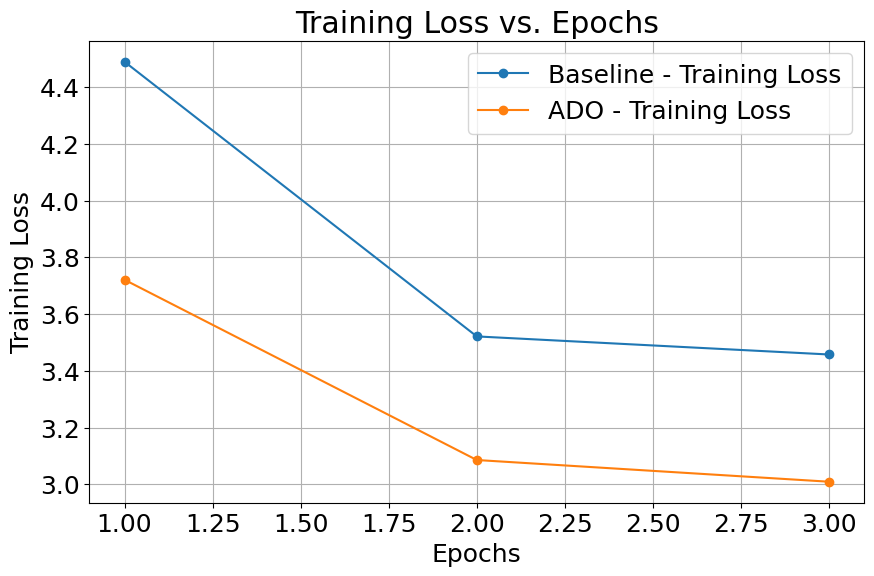

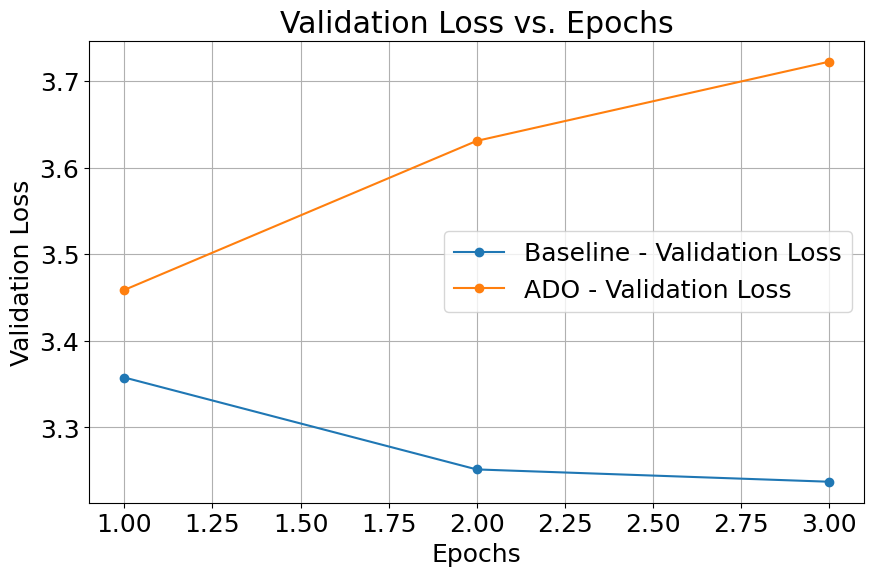

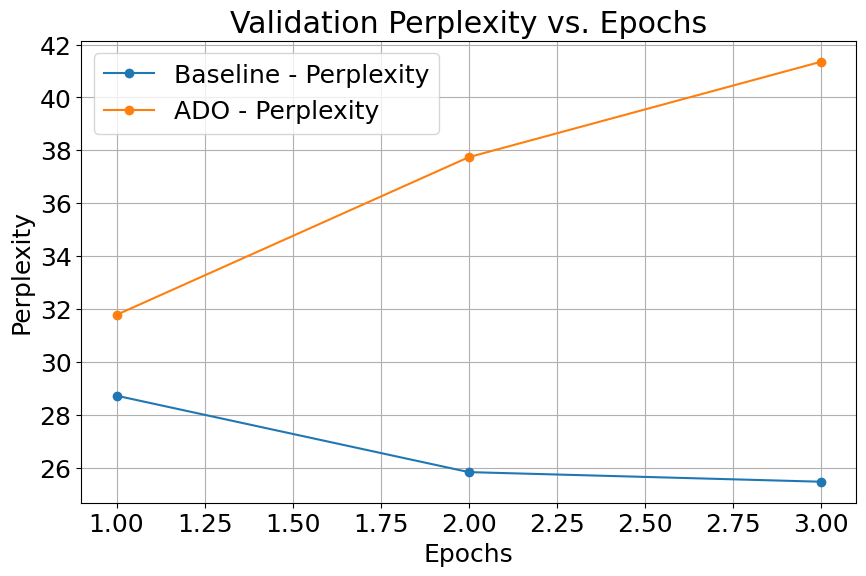

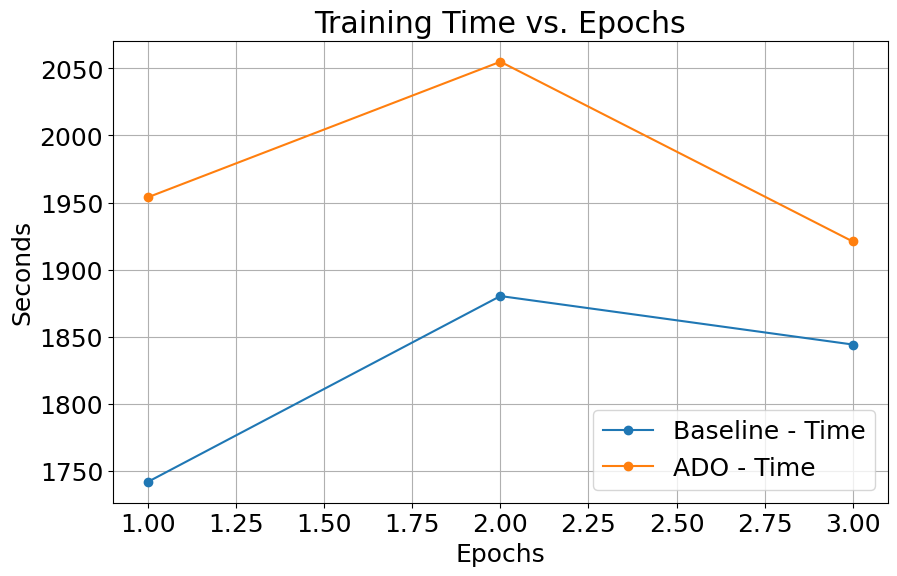

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

font = {'font.size'   : 18}
plt.rcParams.update(font)

# Data is inputed by hand here for simplicity
epochs = [1, 2, 3]
baseline_training_loss = [4.4894, 3.5213, 3.4576]
ado_training_loss = [3.7210, 3.0857, 3.0092]

baseline_val_loss = [3.3576, 3.2515, 3.2373]
ado_val_loss = [3.4587, 3.6307, 3.7221]

baseline_perplexity = [28.7192, 25.8288, 25.4652]
ado_perplexity = [31.7764, 37.7400, 41.3496]

baseline_time = [1741.87, 1880.30, 1844.16]
ado_time = [1954, 2055, 1921]

# Training Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline_training_loss, label="Baseline - Training Loss", marker="o")
plt.plot(epochs, ado_training_loss, label="ADO - Training Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Validation Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline_val_loss, label="Baseline - Validation Loss", marker="o")
plt.plot(epochs, ado_val_loss, label="ADO - Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Perplexity Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline_perplexity, label="Baseline - Perplexity", marker="o")
plt.plot(epochs, ado_perplexity, label="ADO - Perplexity", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Validation Perplexity vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Time Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline_time, label="Baseline - Time", marker="o")
plt.plot(epochs, ado_time, label="ADO - Time", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Seconds")
plt.title("Training Time vs. Epochs")
plt.legend()
plt.grid()
plt.show()

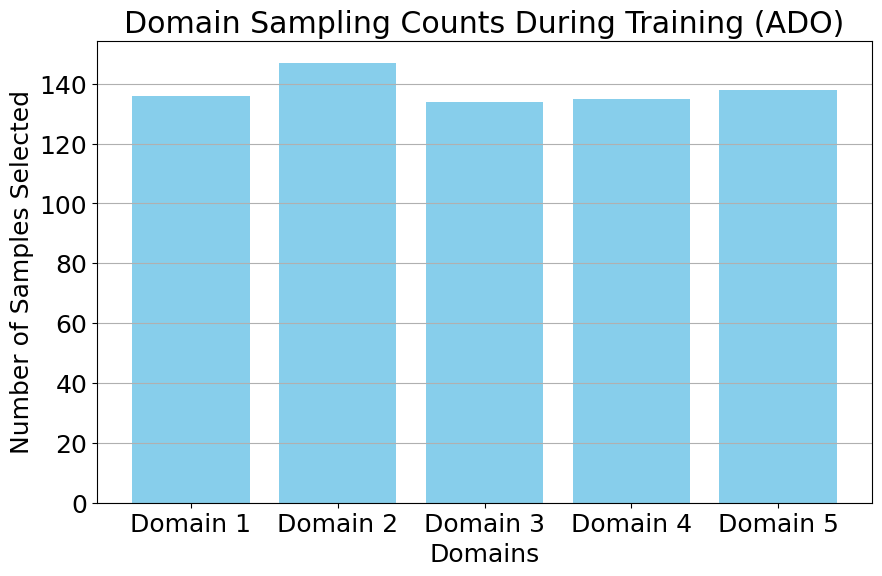

In [ ]:
# Load data from saved logs
import json
with open("ado_training_logs.json", "r") as f:
    logs = json.load(f)

domain_sampling_counts = logs["domain_sampling_counts"]

# Plot domain sampling counts
plt.figure(figsize=(10, 6))
plt.bar(range(len(domain_sampling_counts)), domain_sampling_counts, color='skyblue')
plt.xlabel("Domains")
plt.ylabel("Number of Samples Selected")
plt.title("Domain Sampling Counts During Training (ADO)")
plt.xticks(range(len(domain_sampling_counts)), [f"Domain {i+1}" for i in range(len(domain_sampling_counts))])
plt.grid(axis='y')
plt.show()


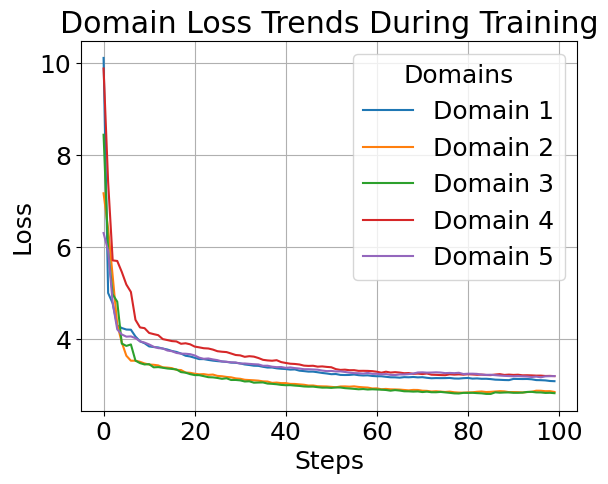

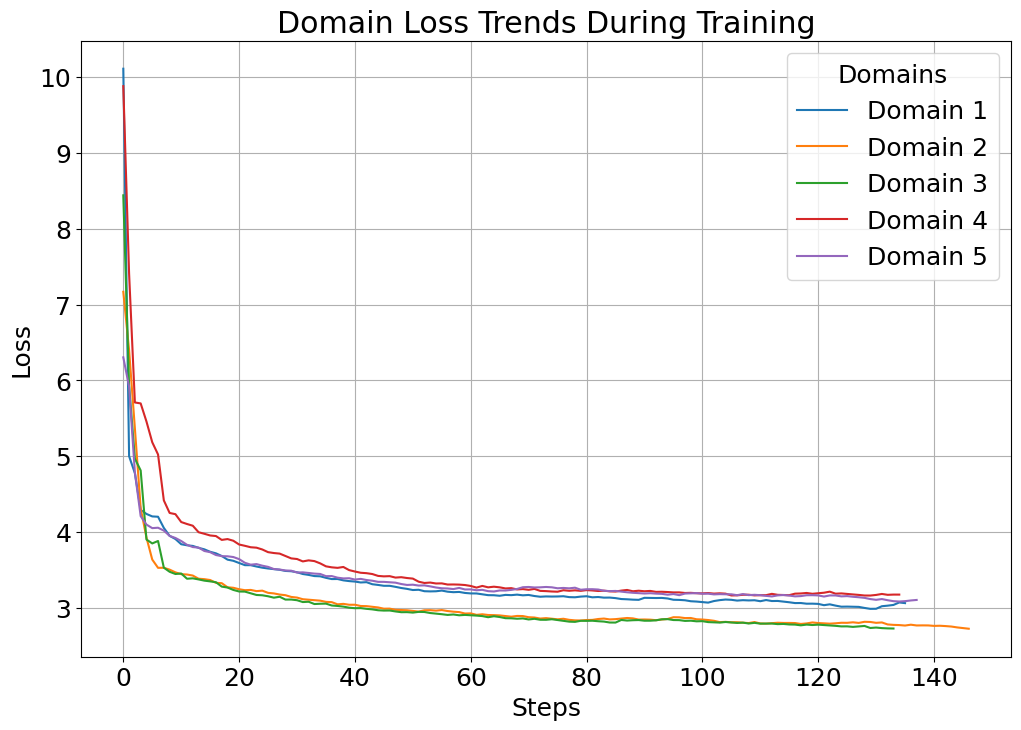

In [ ]:
# Load domain loss history
domain_loss_history = logs["domain_loss_history"]

# Print first 100 for better visualization
for domain_idx, losses in domain_loss_history.items():
    plt.plot(losses[:100], label=f"Domain {int(domain_idx)+1}")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Domain Loss Trends During Training")
plt.legend(title="Domains")
plt.grid()
plt.show()

# Plot domain loss trends complete
plt.figure(figsize=(12, 8))
for domain_idx, losses in domain_loss_history.items():
    plt.plot(losses, label=f"Domain {int(domain_idx)+1}")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Domain Loss Trends During Training")
plt.legend(title="Domains")
plt.grid()
plt.show()
